# Dram Shop Principal Component Analysis (PCA)

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_gbq

from google.cloud import bigquery
from google.oauth2 import service_account
from sklearn.decomposition import PCA

## GBQ setup

In [77]:
# These first two values will be different on your machine. 
service_path = "/Users/xinbu/Desktop/ADA/Repos/assignment-pca-dram-Xin-Bu/"

service_file = 'umt-msba-gg-key.json'  
gbq_proj_id = 'umt-msba'

# And this should stay the same. 
private_key =service_path + service_file

In [78]:
# Now we pass in our credentials so that Python has permission to access our project.
credentials = service_account.Credentials.from_service_account_file(service_path + service_file)

In [79]:
# And finally we establish our connection
client = bigquery.Client(credentials = credentials, project=gbq_proj_id)

In [80]:
for item in client.list_datasets() : 
    print(item.full_dataset_id)

umt-msba:dram_shop
umt-msba:transactions
umt-msba:wedge_example
umt-msba:wedge_transactions


## GBQ Query

In [43]:
gross_sales = """ 
            SELECT customer_id,
                   beverage,
                   SUM(gross_sales) AS gross_sales
            FROM `umt-msba.dram_shop.dram_items_*` AS ds
            LEFT JOIN `umt-msba.dram_shop.item_lookup` AS lk
                    ON ds.item=lk.item
            WHERE customer_id IS NOT NULL
                  AND lk.beverage IN (
                                      SELECT beverage
                                      FROM `umt-msba.dram_shop.item_lookup` AS lk
                                      LEFT JOIN `umt-msba.dram_shop.dram_items_*` AS sd
                                      ON lk.item=sd.item
                                      WHERE beverage IS NOT NULL
                                      GROUP BY beverage
                                      ORDER BY SUM(gross_sales) DESC
                                      LIMIT 1000 
                                      )
                  AND beverage != "custom amount"
            GROUP BY customer_id, beverage
            ORDER BY gross_sales DESC
            """

lo= pandas_gbq.read_gbq(gross_sales, project_id = gbq_proj_id)

Downloading: 100%|██████████| 275713/275713 [00:11<00:00, 23840.85rows/s]


In [44]:
new_lo=lo.pivot(index="customer_id", columns="beverage", values= "gross_sales")

In [45]:
# Fill NA with 0.
beverage=new_lo.fillna(0)
beverage

beverage,$15flight!,$2 ipa - fourth anniversary party,$5 beer!,$6 beer!,$6 token,'jamaica' orange sour with hibiscus,(mountains walking) yamabiko japanese lager 16oz can,*** tasting/seasonal/event ***,*roca altxerri camino,- all day ipa,...,wolf point strawberry wheat,wolf pup,woot stout,yaak attack ipa,yamabiko rice lager,yard sale amber,yellow snow,zero day double ipa,zymopunk pilsner,¡viva la pineapple!
customer_id,,,,,,,,,,,,,,,,,,,,,
",",0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,8.75,7.5,...,13.5,0.0,0.0,54.0,0.0,0.0,23.0,9.0,0.0,0.0
",",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,10.0,5.0,0.0,0.0,0.0,0.0,0.0
", ,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
", ,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
", , ,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zszfbk5uVoxrUZOn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0,0.0,0.0
zvFsSFDDhGlLHGVU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zvZxFT28H_Td2Yx2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
beverage_summary = beverage.iloc[:,:].sum().reset_index() 
beverage_summary = beverage_summary.rename(columns={0:"total_sales"})
beverage_summary = beverage_summary.set_index("beverage")

In [47]:
beverage_summary

,total_sales
beverage,
$15flight!,1410.00
$2 ipa - fourth anniversary party,1232.00
$5 beer!,1110.00
$6 beer!,1110.00
$6 token,2988.00
...,...
yard sale amber,2324.25
yellow snow,939.00
zero day double ipa,3246.25


In [48]:
beverage_summary.sort_values(by="total_sales").tail(n=10)

,total_sales
beverage,
carlsberg,32139.72
all day ipa,40683.50
pilsner,47993.25
grapefruit raddler,49463.25
29p cask beer,49915.50
helles lager,58014.75
ipa,62398.25
super pils,103537.75
kombucha,242883.75


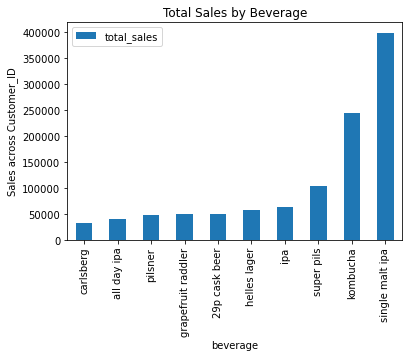

In [49]:
beverage_summary.sort_values(by='total_sales').tail(n=10).plot(kind="bar")
plt.title("Total Sales by Beverage")
plt.ylabel("Sales across Customer_ID")
plt.show()

## PCA on Dram Shop Sales

In [50]:
pca = PCA()

In [51]:
# Fit the pca model to all of the columns. 
pca.fit(beverage)

PCA()

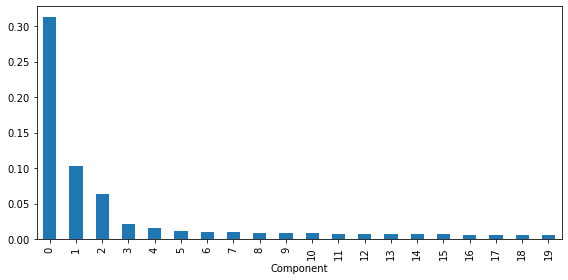

In [52]:
# Get explained variance ratio from the PCA model and save it as a dataframe. 
# The variation explained by the component. A lot of variation was explained by number 0, the first component.
explained_variance = pd.DataFrame(pca.explained_variance_ratio_)
ax = explained_variance.head(20).plot.bar(legend=False, figsize=(8, 4)) 
ax.set_xlabel('Component')
plt.tight_layout()
plt.show()

In [53]:
# Take the cumulative sum of the explained variance ratio.
cume_explained_variance = pd.DataFrame(pca.explained_variance_ratio_).cumsum()

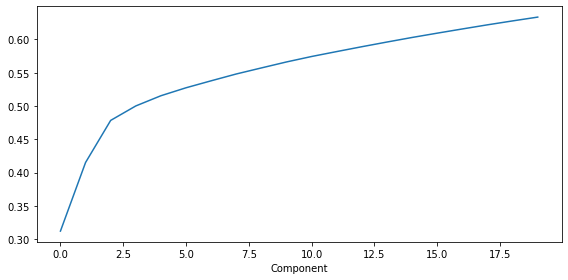

In [54]:
# Plot the cumulative sum of explained variation in the first 20 components. 
ax = cume_explained_variance.head(20).plot.line(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
plt.tight_layout()
plt.show()

The chart above shows the explained variation in the first 20 components, which can explain about 65% of the dependant variable. 

### Investigate Loadings

In [55]:
# Set a variable named "loadings". Get the components.
loadings = pd.DataFrame(pca.components_, columns=beverage.columns[::])
# Use transpose to switch rows and columns.
loadings.transpose().sort_values(0)

,0,1,2,3,4,5,6,7,8,9,...,988,989,990,991,992,993,994,995,996,997
beverage,,,,,,,,,,,,,,,,,,,,,
growler - 64 oz miir stainless,-0.000100,0.000153,-0.000119,0.000235,0.000456,0.001902,0.001389,-0.000630,-0.001259,-0.000802,...,4.195862e-17,-7.697835e-18,3.903128e-18,-6.586528e-17,4.445229e-18,3.870602e-17,3.507394e-17,1.268855e-17,-4.526544e-17,-2.485533e-17
montana bottle opener,-0.000060,-0.000089,-0.000055,-0.000070,0.000019,0.000438,0.000253,-0.000526,0.000778,0.000285,...,-2.097931e-17,-3.057450e-17,-1.166602e-16,4.613280e-17,6.873842e-17,-8.998878e-18,-3.019503e-17,4.994784e-17,4.282599e-18,3.577867e-17
$6 beer!,-0.000051,-0.000090,0.000066,-0.000093,-0.000148,-0.000307,-0.000016,-0.000125,0.000050,-0.000028,...,7.449661e-17,-1.621647e-16,-3.945625e-16,7.041398e-17,2.624402e-16,-3.813163e-17,-1.441307e-16,1.030507e-16,-8.631734e-18,-6.831464e-17
dissident 2014,-0.000045,-0.000017,-0.000092,0.000091,0.000094,0.000149,-0.000167,-0.000004,0.000022,-0.000145,...,-6.938894e-18,-6.570265e-17,-4.336809e-17,7.058156e-17,4.748806e-17,-4.878910e-17,-4.553649e-18,-6.105413e-18,8.131516e-18,4.542807e-17
$6 token,-0.000040,0.000560,-0.000261,-0.000082,-0.001544,-0.000689,-0.000503,0.000996,0.000908,-0.000427,...,-3.260509e-18,-9.210751e-18,-4.933751e-17,8.861556e-17,1.725959e-17,1.125820e-17,2.616329e-17,-5.746940e-18,2.013234e-18,7.519424e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
celebration,0.028518,0.012867,0.028719,0.359265,0.077849,-0.167777,0.332274,0.127039,0.030450,0.013223,...,1.040834e-17,-1.474515e-17,2.081668e-17,2.992398e-17,-2.602085e-17,1.040834e-17,2.038300e-17,-6.776264e-18,-2.059984e-17,-7.502679e-17
ipa,0.029442,0.026277,0.043501,0.398530,0.501636,-0.275974,-0.260474,-0.096444,0.054004,-0.064253,...,3.469447e-18,-1.214306e-17,-5.551115e-17,5.204170e-18,2.775558e-17,3.642919e-17,-2.602085e-17,1.067939e-17,2.255141e-17,-1.040834e-17
super pils,0.051571,0.112338,0.920386,-0.125010,-0.086288,-0.164969,0.014051,-0.248554,-0.029477,-0.008745,...,-9.161508e-18,-2.005774e-18,2.211772e-17,-4.147073e-18,2.114194e-17,-7.264155e-18,-6.965999e-18,-1.812651e-19,3.361027e-18,1.078781e-17


<ipython-input-56-4b3b67427aab>:3: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  pc_loading = loadings.loc[0, :].sort_values(0).tail(n=15)


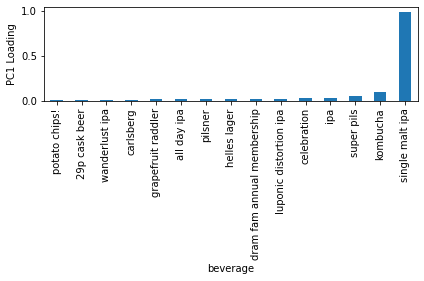

In [56]:
# Present the top 15 loadings for the first component. Load the dataframe just made. 
# Select the first column from all the components; sort_values(0). 0 is columnwise
pc_loading = loadings.loc[0, :].sort_values(0).tail(n=15)
pc_loading.plot.bar()
plt.ylabel("PC1 Loading")
plt.tight_layout()
plt.show() 

In [67]:
# A function that takes all loadings whose absolute value is above the cutoff 0.05.
def show_component(component,num=15, cutoff = 0.05) : 
    pc_loading = loadings.transpose().iloc[:,component-1]
    pc_loading = pc_loading.loc[pc_loading.abs() > cutoff].sort_values()
    max_pc = max(pc_loading.abs())
    colors = ['C0' if l > 0 else 'C1' for l in pc_loading]

    pc_loading.plot.bar(color = colors)
    ax = plt.gca()
    plt.axhline(y=0,c="#888888")
    ax.set_ylim(-max_pc, max_pc)
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()

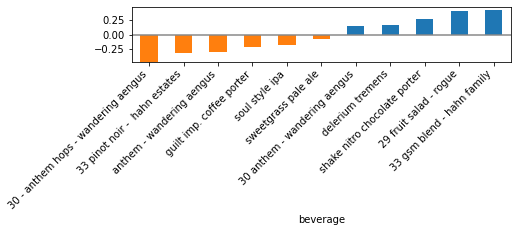

In [70]:
# The first component
show_component(0,0.05)

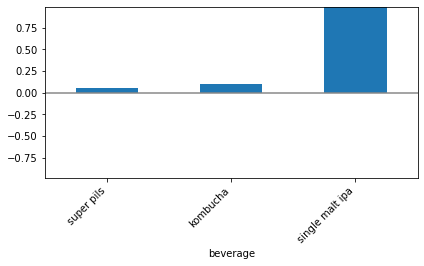

In [71]:
# The second component
show_component(1,0.05)

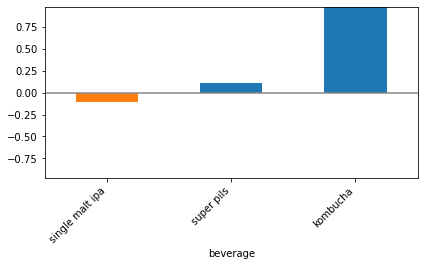

In [72]:
# The third component
show_component(2,0.05)

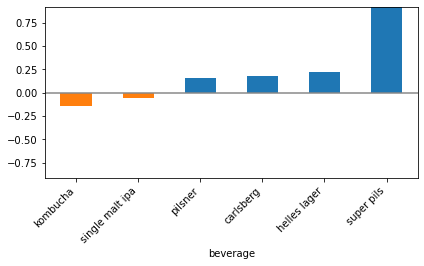

In [73]:
# The fourth component
show_component(3,0.05)

<ipython-input-67-bb9a145edc8a>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


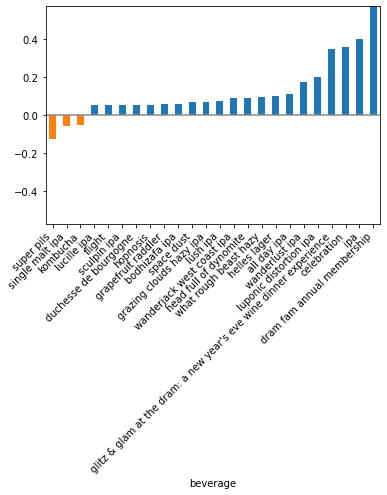

In [74]:
# The fifth component
show_component(4,0.05)

<ipython-input-67-bb9a145edc8a>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


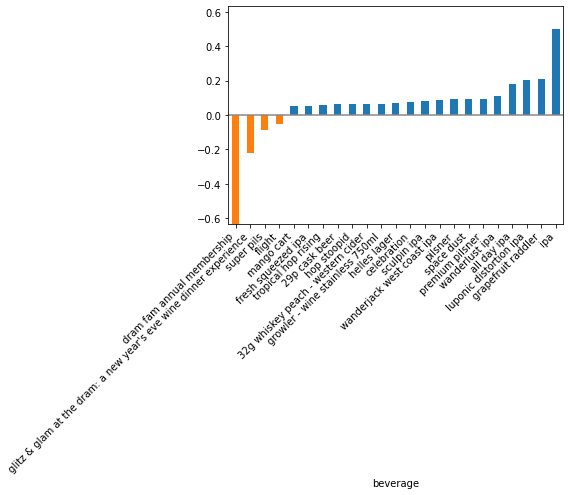

In [75]:
# The six component
show_component(5,0.05)